In [1]:
import numpy as np
alldeploys=["Wizard","ManaTower","Executioner","Ghost"]
allabilities=["Fireball","Execute","Haunt"]
allnotarget=["HealSpell","ExorcismSpell"]
allmoves=['EndTurn']
alldeploysquares=[]
allhandcards=alldeploys+allnotarget
for card in alldeploys:
    alldeploysquares.extend([card+str(x) for x in range(4)])
allmoves.extend(alldeploysquares)
for move in allabilities:
    allmoves.extend([move+str(x) for x in range(4)])
allmoves.extend([allnotarget[x] for x in range(2)])
def encodehand(hand,length=len(allhandcards)):
    small=len(allhandcards)
    return [hand.count(x) if x in hand else 0 for x in allhandcards]+[0]*max(0,length-small)
def encodemove(move,length=len(allmoves)):
    small=len(allmoves)
    return [1 if x==move else 0 for x in allmoves]+[0]*max(0,length-small)
def encodemoves(moves,length=len(allmoves)):
    small=len(allmoves)
    return [1 if x in moves else 0 for x in allmoves]+[0]*max(0,length-small)
def encodedeployed(troops,length=len(alldeploysquares)):
    small=len(alldeploysquares)
    return [1 if x in troops else 0 for x in alldeploysquares]+[0]*max(0,length-small)
def encodehealths(troops):

    return [troop.health if hasattr(troop,"health") else 0 for troop in troops]+[0]*(4-len(troops))



In [2]:
# -----------------------------
# Game controller
# -----------------------------
class Game:
    def __init__(self, player_1, player_2, length=10, prnt=True, offset=[0,2],show=False):
        self.turn = 0
        self.prnt = prnt
        self.moves_played = 0
        self.length = length
        self.game_over = False
        self.players = [player_1, player_2]
        player_1.game = self
        player_2.game = self
        player_1.team = 0
        player_2.team = 1
        player_2.base_health += offset[0]
        player_2.mana += offset[1]
        self.boards=[]
        self.show=show
        self.player_1=player_1
        self.player_2=player_2
    def change_turn(self):
        self.turn = 1 - self.turn

    def play(self):
        while self.moves_played < self.length and not self.game_over:
            player = self.players[self.turn]
            opponent = self.players[self.turn-1]
            if self.prnt:
                print(f"\n--- Turn {self.moves_played}, Player {self.turn+1} ---")
            player.make_move(self)
            if self.show:
                self.show_board()
            
        return self.end_game()

    def end_game(self):
        p1, p2 = self.players
        if p1.base_health > p2.base_health:
            return 1
        elif p1.base_health < p2.base_health:
            return -1
        return 0
    def show_board(self):
        print("----------------------------------------------")
        print("Current Board:")
        print(f"Player 2 Health:{self.player_2.base_health}")
        print(f"Player 2 Mana:{self.player_2.mana}")
        print("Player 2 cards in hand:")
        print(*[card.name for card in self.player_2.deck])
        print("Player 2 troops deployed:")
        print(*[square.troop.name if not square.empty else "____" for square in self.player_2.available_squares])
        print("Player 1 troops deployed:")
        print(*[square.troop.name if not square.empty else "____" for square in self.player_1.available_squares])
        print("Player 1 cards in hand:")
        print(*[card.name for card in self.player_1.deck])
        print(f"Player 1 Health:{self.player_1.base_health}")
        print(f"Player 1 Mana:{self.player_1.mana}")
        print("----------------------------------------------")

In [3]:
from collections import deque
# -----------------------------
# GamePlayer
# -----------------------------
class GamePlayer:
    def __init__(self, difficulty, game, deck, decision_maker,length=len(allmoves)):
        self.difficulty = difficulty
        self.game = game
        # Start with the full deck as "largedeck"
        self.largedeck = deque(deepcopy(deck))
        self.deck = []  # current hand (max 5)
        self.active_cards = []
        self.decision_maker = decision_maker
        self.team = None
        self.available_squares = [Square(i) for i in range(4)]
        self.mana = 25
        self.base_health = 25
        # draw initial hand
        self.draw_cards()
        self.move="EndTurn"
        snapshot = {
           
            "My_Mana": [self.mana],
            "Their_Mana": [self.mana],
            "My_Health": [self.base_health],
            "Their_Health": [self.base_health],
            "Their_Card_Types_Seen":encodehand([0]),
            "Their_Currently_Visible_Cards": encodedeployed([0,0,0,0]),
            "Their_cardhealths":[0]*4,
            "Your cardhealths":[0]*4,
            "Active_Cards":encodedeployed([0,0,0,0]),
            "Deck":encodehand(self.deck),
            "Action Taken":encodemove(self.move)
        }
        self.information=[]
        for key in snapshot.keys():
            self.information.extend(snapshot[key])
        self.known_enemy_types = set()
        self.passive_effectors=[]
        
    def clone(self):
        return deepcopy(self)

    def draw_cards(self):
        """Refill hand up to 5 cards from largedeck."""
        while len(self.deck) < 5 and self.largedeck:
            
            self.deck.append(self.largedeck.pop())

    def refresh_deck(self):
        """Call this at the start of a turn to ensure 5 cards in hand."""
        self.draw_cards()

    def get_possible_moves(self, game):
        moves = [EndTurnMove(self)]
        # Only consider cards that are alive
        extend_deck = [c for c in self.deck + self.active_cards]

        for card in extend_deck:
            moves.extend(card.get_possible_moves(game,self))

        return moves

    def make_move(self, game):
        moves = self.get_possible_moves(game)
        if moves:
            move = self.decision_maker.choose_move(moves,self.information)
            self.move=move.movename
            move.execute(game)
    

    def record_information(self, game,opponent,length=31):
        
        visible_enemy_cards = [c for c in opponent.active_cards if not getattr(c, "hidden", False)]

        # update memory of seen types
        self.known_enemy_types.update(c.name+str(c.square.index) for c in visible_enemy_cards)
        
        enemy_list=list(self.known_enemy_types) +[0]*(length-len(self.known_enemy_types))
        
        snapshot = {
           
            "My_Mana": [int(self.mana)],
            "Their_Mana": [int(opponent.mana)],
            "My_Health": [int(self.base_health)],
            "Their_Health": [int(opponent.base_health)],
            "Their_Card_Types_Seen":encodehand(enemy_list) ,
            "Their_Currently_Visible_Cards": encodedeployed([square.troop.name+str(square.index) if not square.empty else "0" for square in opponent.available_squares]),
            "Their_cardhealths":encodehealths(opponent.active_cards),
            "Your cardhealths":encodehealths(self.active_cards),
            "Active_Cards":encodedeployed([square.troop.name+str(square.index) if not square.empty else "0" for square in self.available_squares]),
            "Deck":encodehand([c.name for c in self.deck]),
            "Action Taken":encodemove(self.move)
            
        }
      
        self.information=[]
        for key in snapshot.keys():
            self.information.extend(snapshot[key])
    def invigorate(self):
        for card in self.active_cards:
            card.exhausted=False
    def employ_effects(self):
        for effect in self.passive_effectors:
            effect.tick(self)

In [4]:
class Effect:
    def __init__(self, owner, source=None):
        self.owner = owner      # usually the player
        self.source = source    # the troop or item that caused this effect
        self.active = True

    def tick(self, effects):
        pass


class ManaTowerEffect(Effect):
    def tick(self,player):
        if player.game.prnt:
            print(f"{self.source.name} grants +1 mana.")
        self.owner.mana += 1

In [5]:
from abc import ABC, abstractmethod
from copy import deepcopy

# -----------------------------
# Card base class
# -----------------------------
class Card(ABC):
    def __init__(self, type_="", team=0, mana_cost=0, name="", hidden=False):
        self.type = type_
        self.team = team
        self.mana_cost = mana_cost
        self.name = name
        self.hidden = hidden
        self.deployed = False
        self.dead = False
        self.square = None
        self.exhausted=False
        self.health=0
        self.initial_health=0
    
    def get_possible_moves(self, game, player):
        pass
    def die(self, player):
        """Troop dies and returns to largedeck for reuse."""
        
        self.deployed = False
        if self in player.active_cards:
            player.active_cards.remove(self)
        if self in player.deck:
            player.deck.remove(self)
        player.largedeck.appendleft(self)  # Recycle the card
        self.square = None
        self.health=self.initial_health
# -----------------------------
# WizardCard
# -----------------------------
class WizardCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="troop", team=team, mana_cost=6,name="Wizard")
        self.initial_health=10
        self.health = 10
        self.hidden=False
        self.exhausted=False
        self.ability_cost=6

    def get_possible_moves(self, game, player):
        self.player = player
        moves = []
        if not self.deployed and player.mana>=self.mana_cost:
            for sq in player.available_squares:
                if sq.empty:
                    moves.append(DeployTroopMove(self, sq,player))
        else:
            opponent = game.players[1 - player.team]
            if player.mana >= self.ability_cost and not self.exhausted and self.deployed:
                for sq in opponent.available_squares:
                    moves.append(FireballMove(self, sq,player))
        return moves

# -----------------------------
# WizardCard
# -----------------------------
class GhostCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="troop", team=team, mana_cost=6, name="Ghost")
        self.health = 6
        self.initial_health=6
        self.hidden=True
        self.exhausted=False
        self.ability_cost=2
        self.damage=1
        
    def get_possible_moves(self, game, player):
        self.player = player
        moves = []
        if not self.deployed and player.mana>=self.mana_cost:
            for sq in player.available_squares:
                if sq.empty:
                    moves.append(DeployTroopMove(self, sq,player))
        else:
            opponent = game.players[1 - player.team]
            if player.mana >= self.ability_cost and not self.exhausted and self.deployed:
                for sq in opponent.available_squares:
                    moves.append(HauntMove(self,sq,self.damage,self.ability_cost,player))

        return moves
    def die(self,player):
        super().die(player)
        self.ability_cost=2
        self.damage=1
        

class HealCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="spell", team=team, mana_cost=4, name="HealSpell")
        self.health = 1000
        self.hidden=True
        self.exhausted=False
        self.ability_cost=1000
    def get_possible_moves(self, game, player):
        self.player = player
        

        opponent = game.players[1 - player.team]
        if player.mana >= 4 and not self.exhausted:
             

            return [HealMove(self,player)]
        return []
class ExorcismCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="spell", team=team, mana_cost=4, name="ExorcismSpell")
        self.health = 1000
        self.hidden=True
        self.exhausted=False
        
    def get_possible_moves(self, game, player):
        self.player = player
        

        opponent = game.players[1 - player.team]
        if player.mana >= self.mana_cost and not self.exhausted:
             

            return [ExorcismMove(self,player)]
        return []

In [6]:
# -----------------------------
# ExecutionerCard
# -----------------------------
class ExecutionerCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="troop", team=team, mana_cost=6,name="Executioner")
        self.initial_health=12
        self.health = 12
        self.hidden=False
        self.exhausted=False
        self.ability_cost=6
        self.execution_threshold=200

    def get_possible_moves(self, game, player):
        self.player = player
        moves = []
        if not self.deployed and player.mana>=self.mana_cost:
            for sq in player.available_squares:
                if sq.empty:
                    moves.append(DeployTroopMove(self, sq,player))
        else:
            opponent = game.players[1 - player.team]
            if player.mana >= self.ability_cost and not self.exhausted and self.deployed:
                for sq in [square for square in opponent.available_squares if not square.empty and not square.troop.hidden]:
                    if sq.troop.health<=.01*self.execution_threshold*sq.troop.initial_health:
                        moves.append(ExecutionerMove(self, sq,player))
        return moves

# -----------------------------
# ExecutionerCard
# -----------------------------

In [7]:
class ManaTowerCard(Card):
    def __init__(self,team=0):
        super().__init__(type_="troop",team=team,mana_cost=3,name="ManaTower")
        self.initial_health=4
        self.health=self.initial_health
        self.hidden=False
        self.exhausted=False
        self.ability_cost=6
        self.effect=None
        self.deployed=False
    def get_possible_moves(self, game, player):
        self.player = player
        moves = []
        if not self.deployed and player.mana>=self.mana_cost:
            for sq in player.available_squares:
                if sq.empty:
                    moves.append(DeployManaTowerMove(self, sq,player))
        return moves
    def die(self,player):
         
        super().die(player)
        player.passive_effectors.remove(self.effect)
        

In [8]:
# -----------------------------
# Square and BuffSquare
# -----------------------------
class Square:
    def __init__(self, index, troop=Card()):
        self.index = index
        self.troop = troop
        self.empty = True

class BuffSquare:
    def __init__(self):
        self.empty = True

In [9]:
# -----------------------------
# Move base class
# -----------------------------
class Move(ABC):
    @abstractmethod
    def execute(self, game):
        pass

# -----------------------------
# DeployTroopMove
# -----------------------------
class DeployTroopMove(Move):
    def __init__(self, card, square,player):
        self.card = card
        self.square = square
        self.mana_cost = card.mana_cost
        self.player=player
        self.type="Deploy"
        self.movename=card.name+str(square.index)
    def execute(self, game):
        player=self.player
        if self.player.mana < self.mana_cost:
            if game.prnt:
                print(f"❌ Not enough mana to deploy {self.card.name}!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        player.mana -= self.mana_cost
        self.square.troop = self.card
        self.square.empty = False
        self.card.deployed = True
        self.card.square = self.square
        if self.card in player.deck:
            player.deck.remove(self.card)
        player.active_cards.append(self.card)
        player.move_played=(self.card.name,self.square.index)
        if game.prnt:
            print(f"🧙 {self.card.name} deployed on square {self.square.index}. Mana: {player.mana}")
class DeployManaTowerMove(Move):
    def __init__(self, card, square,player):
        self.card = card
        self.square = square
        self.card.effect=ManaTowerEffect(player,card)
        self.player=player
        self.mana_cost=self.card.mana_cost
        self.type="Deploy"
        self.movename=card.name+str(square.index)
    def execute(self, game):
        player=self.player
        if self.player.mana < self.mana_cost:
            if game.prnt:
                print(f"❌ Not enough mana to deploy {self.card.name}!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        player.mana -= self.mana_cost
        self.square.troop = self.card
        self.square.empty = False
        self.card.deployed = True
        self.card.square = self.square
        if self.card in player.deck:
            player.deck.remove(self.card)
        player.active_cards.append(self.card)
        if game.prnt:
            print(f"🧙 {self.card.name} deployed on square {self.square.index}. Mana: {player.mana}")
        self.player.passive_effectors.append(self.card.effect)
        

class FireballMove(Move):
    def __init__(self, caster, target_square,player):
        self.caster = caster
        self.target_square = target_square
        self.mana_cost = caster.ability_cost
        self.player=player
        self.type="DamageAbility"
        self.name="Fireball"
        self.movename=self.name+str(target_square.index)
    def execute(self, game):
        player=self.player
        if player.mana < self.mana_cost and not self.caster.exhausted:
            if game.prnt:
                print("❌ Not enough mana for fireball!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        player.mana -= self.mana_cost
        opponent = game.players[1 - player.team]
        squares = opponent.available_squares
        idx = squares.index(self.target_square)
        self.caster.exhausted=True

        if game.prnt:
            print(f"Player{player.team+1}'s Wizard on square {self.caster.square.index} casts Fireball at enemy square {idx}! Mana left: {player.mana}")

        splash_indices = [i for i in [idx-1, idx, idx+1] if 0 <= i < len(squares)]
        splash_damage = 6 / len(splash_indices)
        overkill = 0

        for i in splash_indices:
            sq = squares[i]
            if not sq.empty and sq.troop and hasattr(sq.troop, "health") and not sq.troop.dead:
                sq.troop.health -= splash_damage
                if game.prnt:
                    print(f"🔥 {splash_damage:.1f} dmg to {sq.troop.name} on square {i} (remaining {sq.troop.health:.1f})")
                if sq.troop.health <= 0:
                    overkill += -sq.troop.health
                    if game.prnt:
                        print(f"💀 {sq.troop.name} on square {i} destroyed!")
                    sq.troop.die(opponent)
                    sq.troop = None
                    sq.empty = True
            else:
                overkill += splash_damage  # hitting empty square counts as overkill

        if overkill > 0:
            opponent.base_health -= min(overkill,2)
            if game.prnt:
                print(f"🏰 {overkill:.1f} overkill damage to opponent base! Remaining: {opponent.base_health:.1f}")

        if opponent.base_health <= 0:
            if game.prnt:
                print("🎉 Opponent base destroyed! Game over.")
            game.game_over = True
class HauntMove(Move):
    def __init__(self, caster, target_square,damage,mana_cost,player):
        self.caster = caster
        self.target_square = target_square
        self.mana_cost = mana_cost
        self.damage=damage
        self.player=player
        self.type="DamageAbility"
        self.name="Haunt"
        self.movename=self.name+str(target_square.index)
    def execute(self, game):
        player=self.player
        if player.mana < self.mana_cost and not self.caster.exhausted:
            if game.prnt:
                
                print("❌ Not enough mana for haunt!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        player.mana -= self.mana_cost
        opponent = game.players[1 - player.team]
        squares = opponent.available_squares
        idx = squares.index(self.target_square)
        self.caster.exhausted=True

        if game.prnt:
            print(f"Player{player.team+1}'s Ghost on square {self.caster.square.index} casts Haunt at enemy square {idx}! Mana left: {player.mana}")

        
        if not self.target_square.empty:
            self.target_square.troop.health-=self.damage
            if game.prnt:
                print(f" {self.damage} damage to opponent at square {idx} Remaining: {self.target_square.troop.health:.1f}")
            if self.target_square.troop.health<=0:
                if game.prnt:
                    print(f" {self.target_square.troop.name} at square {idx} has died!")
                self.target_square.troop.die(opponent)
                self.target_square.troop = None
                self.target_square.empty = True
                
        
            
            
        

        
        if game.prnt:
            print(f" {self.damage} damage to opponent base! Remaining: {opponent.base_health:.1f}")    
        self.caster.damage+=1
        self.caster.ability_cost+=2
        opponent.base_health-=self.damage
        

        if opponent.base_health <= 0:
            if game.prnt:
                print("🎉 Opponent base destroyed! Game over.")
            game.game_over = True
class HealMove(Move):
    def __init__(self,card,player):
        self.card=card
        self.player=player
        self.mana_cost = 6
        self.type="NoTargetSpell"
        self.movename=card.name
    def execute(self, game):
        self.player.mana-=self.mana_cost
        if game.prnt:
            print(f"Player {self.player.team+1} casts heal!")
        if self.player.active_cards:
            for card in self.player.active_cards:
                card.health = card.health+2
                if game.prnt and card.square:
                    print(f"Player {self.player.team+1}'s {card.name} on square {card.square.index} is now {card.health} hp!")
        else:
            self.player.base_health+=2
            if game.prnt:
                print(f"Player {self.player.team+1}'s base is healed! Remaining Health:{self.player.base_health} hp!")
            
                  
                
        
            
        self.card.die(self.player)
class ExorcismMove(Move):
    def __init__(self,card,player):
        self.card=card
        self.player=player
        self.mana_cost = card.mana_cost
        self.type="NoTargetSpell"
        self.movename=card.name
    def execute(self, game):
        opponent=game.players[1-self.player.team]
        self.player.mana-=self.mana_cost
        if game.prnt:
            print(f"Player {self.player.team+1} casts Exorcism!")
        if opponent.active_cards:
            for card in opponent.active_cards:
                if card.name=="Ghost":
                    if game.prnt and card.square:
                        print(f"Player {opponent.team+1}'s {card.name} on square {card.square.index} has been Exorcised!")
        
                    card.die(opponent)
        elif game.prnt:
            print(f"No ghosts deployed!")
           
            
                  
                
        
            
        self.card.die(self.player)

# -----------------------------
# EndTurnMove
# -----------------------------
class EndTurnMove(Move):
    def __init__(self, player):
        self.player = player
        self.type="EndTurn"
        self.movename="EndTurn"

    def execute(self, game):
        # End the current player's turn first
        game.change_turn()
        game.moves_played += 1

        # Refresh the new player's deck and info
        new_player = game.players[game.turn]
        old_player = game.players[1 - game.turn]

        old_player.mana += 2
        old_player.refresh_deck()

        
        new_player.invigorate()
        new_player.refresh_deck()
        
        

        if game.prnt:
            print(f"Player {old_player.team+1} ends turn and gains 2 mana.")
        old_player.employ_effects()
        new_player.record_information(game,old_player)
        if game.prnt:
            print(f"Player {old_player.team+1} has {old_player.mana} mana remaining.")

In [10]:
class ExecutionerMove(Move):
    def __init__(self, caster, target_square,player):
        self.caster = caster
        self.target_square = target_square
        self.mana_cost = caster.ability_cost
        self.player=player
        self.execution_threshold=caster.execution_threshold
        self.type="DamageAbility"
        self.name="Execute"
        self.movename=self.name+str(target_square.index)
    def execute(self, game):
        executionThreshhold = self.execution_threshold ######<--PERCENT health threshhold for execution to instantly kill enemy unit-->#####
        sq = self.target_square
        player=self.player
        if player.mana < self.mana_cost and not self.caster.exhausted:
            if game.prnt:
                print("❌ Not enough mana/weak targets for execution!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        if game.prnt:
            print(f"Player{player.team+1}'s Executioner on square {self.caster.square.index} casts Execute at enemy square {self.target_square.index}! ")
        if sq.empty or not sq.troop or not hasattr(sq.troop, "health") or sq.troop.dead:
            if game.prnt:
                print("❌ No targets for execution!")
            return
        if self.target_square.troop.health >= self.target_square.troop.initial_health * (executionThreshhold * 0.01) :
            if game.prnt:
                print("Target is not weak enough for Executioner to execute")
            return
        if game.prnt:
            print(f"Executioner executes {self.target_square.troop.name}  !!! OWNED!!!!")
        
        player.mana -= self.mana_cost
        opponent = game.players[1 - player.team]
        squares = opponent.available_squares
        idx = squares.index(self.target_square)
        self.caster.exhausted=True
        self.target_square.troop.die(opponent)
        self.target_square.troop = None
        self.target_square.empty = True
        if game.prnt:
            print(f"Mana left: {player.mana}")
       

        if opponent.base_health <= 0:
            if game.prnt:
                print("🎉 Opponent base destroyed! Game over.")
            game.game_over = True

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNet(nn.Module):
    def __init__(self, input_dim=87, output_dim=31):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, output_dim)

    def forward(self, state, action_mask):
        # state: (87)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        logits = self.out(x)

        # mask illegal moves by setting them to -inf
        masked_logits = logits.masked_fill(action_mask == 0, float('-inf'))

        # Numerical stability: subtract max(logits)
        masked_logits = masked_logits - masked_logits.max()

        # Softmax + epsilon
        probs = torch.softmax(masked_logits, dim=-1)
        probs = probs + 1e-12

        # Renormalize to ensure sum=1
        probs = probs / probs.sum()

        return probs


In [12]:
def onehotmoves(moves):
        #function takes in a list of move instances and gives a onehot encoding of each
        movenames=[move.movename for move in moves]#contains the NAMES of moves rather than instances ex:"Wizard1" 
        movelist=encodemoves(movenames)#one-hot encoded list of possible moves

        return movelist
def convertanswer(possible_moves, action_index):
    # lookup name of the global move at this index
    movename = allmoves[action_index]

    # find the move instance in the legal list
    for move in possible_moves:
        if move.movename == movename:
            return move

    # fallback (should never happen)
    return possible_moves[0]
    

# -----------------------------
# DecisionMaker (random for now)
# -----------------------------
class DecisionMaker():
    def __init__(self):
        pass
class DumbDecisionMaker(DecisionMaker):
    def __init__(self,name="Dummy"):
       
        self.name=name
    def choose_move(self,possible_moves,information):
        return np.random.choice(possible_moves)
        
class NeuralDecisionMaker(DecisionMaker):
    def __init__(self, policy,name="BigBrain"):
        self.policy = policy
        self.trajectory = []
        self.name=name

    def choose_move(self, possible_moves, information):
        # convert state + mask to tensor
        state = torch.tensor(information, dtype=torch.float32)
        action_mask = torch.tensor(onehotmoves(possible_moves), dtype=torch.float32)

        # get probabilities
        probs = self.policy(state, action_mask)

        # sample action index
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        # store for learning update
        self.trajectory.append({
            "log_prob": dist.log_prob(action),
            "state": state,
            "mask": action_mask
        })

        # convert action index → Move instance
        chosenmove = convertanswer(possible_moves, action.item())
        return chosenmove
def reinforce_update(policy, optimizer, trajectory, reward,health1,mana1,mana2):
    if len(trajectory) == 0:
        return
    
    
    reward-=np.tanh(.03*(2/(.5+health1)) +mana1-.5*mana2)
    
    reward_tensor = torch.tensor(reward, dtype=torch.float32)
    loss = torch.stack([-step["log_prob"] * reward_tensor for step in trajectory]).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    trajectory.clear()

In [13]:
# -----------------------------
# Example simulation
# -----------------------------
class simulator():
    def __init__(self,player1, player2, length=20, prnt=True, offset=[0,0],show=False):
        self.player1=player1
        self.player2=player2
        self.length=length
        self.prnt=prnt
        self.offset=offset
        self.show=show
    def simulate(self):
      
        game = Game(self.player1, self.player2, self.length, self.prnt, self.offset,self.show)
        reward=game.play()
        
        
        returndict={"reward":reward,
                   "health1":game.player_1.base_health,
                   "mana1":game.player_1.mana,
                   "health2":game.player_2.base_health,
                   "mana2":game.player_2.mana}
        return returndict

In [14]:
import numpy as np
from collections import Counter
def make_deck(team=0, size=20, cards=None, prnt=True, limits={}):

    l = []

    if not cards:
        cards = [WizardCard, GhostCard, HealCard, ExorcismCard, ExecutionerCard,ManaTowerCard]

    # Default: no limits (infinite)
    for card in cards:
        if card not in limits:
    
            limits[card] = float('inf')

    # Keep count of how many of each card we've added
    counts = {c: 0 for c in cards}

    while len(l) < size:
        # Choose from cards that haven't hit their limit yet
        available = [c for c in cards if counts[c] < limits[c]]
        if not available:
            raise ValueError("No more cards available — all limits reached before deck filled.")

        card_cls = np.random.choice(available)
        l.append(card_cls(team=team))
        counts[card_cls] += 1

    if prnt:
        print_deck(l)
    return l


def print_deck(deck=None):
    if not deck:
        deck=make_deck()

    print(Counter([item.name for item in deck]))


from IPython.display import display, HTML

display(HTML('''
<style>
.output_scroll {
    height: auto !important;
    max-height: none !important;
}
</style>
'''))

In [15]:
import time
resultholder={}

ddm = DumbDecisionMaker()
toplayagainst = [ddm]
totaltime = 0

for newmodel in range(3):
    
    

    # create new policy + DM
    policy = PolicyNet()
    optimizer = torch.optim.Adam(policy.parameters(), lr=.001)
    dm_new = NeuralDecisionMaker(policy,name=f"Model{newmodel+1}")


     # pick opponent
    
    
    print(f"\n=== TRAINING MODEL #{dm_new.name}")
    start=time.time()
    maxepisodes=250*(newmodel+1)
    for episode in range(maxepisodes):
        dm_opponent = np.random.choice(toplayagainst)
        if f"{dm_new.name}V{dm_opponent.name}" not in resultholder.keys():
            resultholder[f"{dm_new.name}V{dm_opponent.name}"]=[]



        # fresh decks
        deck1 = make_deck(0, size=25, prnt=False)
        deck2 = make_deck(1, size=25, prnt=False)

        # CLONE the opponent DM (important!)
        if isinstance(dm_opponent, NeuralDecisionMaker):
            dm2 = NeuralDecisionMaker(policy=dm_opponent.policy,name=dm_opponent.name)
        else:
            dm2 = DumbDecisionMaker()

        # assign players
        if episode % 2 == 0:
            p1 = GamePlayer(difficulty=1,game=None,deck=deck1, decision_maker=dm_new, length=len(allmoves))
            p2 = GamePlayer(difficulty=1,game=None,deck=deck2, decision_maker=dm2, length=len(allmoves))
            sim = simulator(p1, p2, length=30, prnt=False)
            simresult = sim.simulate()
            reward=simresult["reward"]
            health=simresult["health1"]
            mana1=simresult["mana1"]
            mana2=simresult["mana2"]
        else:
            p1 = GamePlayer(difficulty=1,game=None,deck=deck2, decision_maker=dm2, length=len(allmoves))
            p2 = GamePlayer(difficulty=1,game=None,deck=deck1, decision_maker=dm_new, length=len(allmoves))
            sim = simulator(p1, p2, length=30, prnt=False)
            simresult = sim.simulate()
            reward=-simresult["reward"]
            health=simresult["health2"]
            mana1=simresult["mana2"]
            mana2=simresult["mana1"]
        # update only new model
        reinforce_update(policy, optimizer, dm_new.trajectory, reward,health,mana1,mana2)

        
        if (episode%50==0 and episode>0):
            elapsed = time.time() - start
            totaltime += elapsed
            print(f"Episodes {episode-50} to {episode} took {elapsed:.2f}s, total {totaltime:.2f}s")
            start = time.time()
        if episode==maxepisodes-1:
            elapsed = time.time() - start
            totaltime += elapsed
            print(f"Final training took {elapsed:.2f}s, total {totaltime:.2f}s")
            start = time.time()
            

        resultholder[f"{dm_new.name}V{dm2.name}"].append(reward)
    toplayagainst.append(dm_new)
        


=== TRAINING MODEL #Model1
Episodes 0 to 50 took 2.06s, total 2.06s
Episodes 50 to 100 took 1.84s, total 3.90s
Episodes 100 to 150 took 1.85s, total 5.75s
Episodes 150 to 200 took 1.85s, total 7.60s
Final training took 1.79s, total 9.39s

=== TRAINING MODEL #Model2
Episodes 0 to 50 took 2.37s, total 11.76s
Episodes 50 to 100 took 2.45s, total 14.21s
Episodes 100 to 150 took 2.47s, total 16.68s
Episodes 150 to 200 took 2.32s, total 19.00s
Episodes 200 to 250 took 2.38s, total 21.38s
Episodes 250 to 300 took 2.23s, total 23.61s
Episodes 300 to 350 took 2.51s, total 26.12s
Episodes 350 to 400 took 2.25s, total 28.37s
Episodes 400 to 450 took 2.36s, total 30.73s
Final training took 2.36s, total 33.09s

=== TRAINING MODEL #Model3
Episodes 0 to 50 took 2.58s, total 35.67s
Episodes 50 to 100 took 2.45s, total 38.12s
Episodes 100 to 150 took 2.56s, total 40.68s
Episodes 150 to 200 took 2.38s, total 43.06s
Episodes 200 to 250 took 2.39s, total 45.45s
Episodes 250 to 300 took 2.67s, total 48.12

In [16]:
print("1=Win,-1=Loss,0=Draw")
print(Counter(resultholder["Model2VDummy"]))

1=Win,-1=Loss,0=Draw
Counter({1: 138, -1: 106, 0: 22})


In [22]:
import pandas as pd
c=Counter(resultholder["Model3VModel2"])
winrate=c[1]/len(resultholder["Model3VModel2"])
winrate

0.5833333333333334

In [18]:
resultholder.keys()

dict_keys(['Model1VDummy', 'Model2VModel1', 'Model2VDummy', 'Model3VModel1', 'Model3VModel2', 'Model3VDummy'])

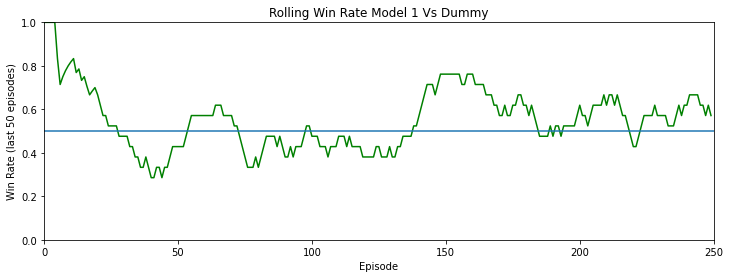

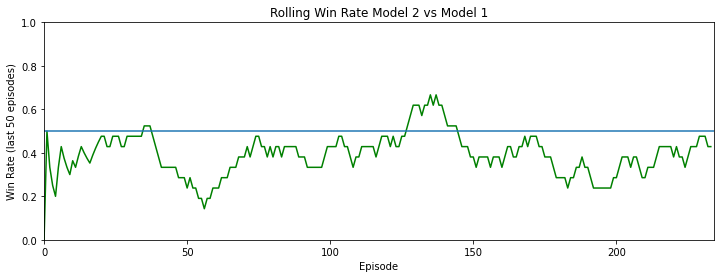

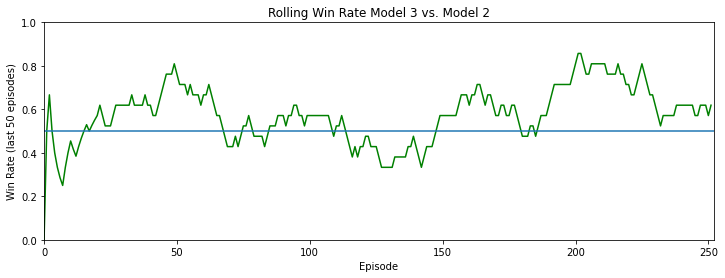

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque



# results is a list of 1=Win, 0=Draw, -1=Loss
results_array = np.array(resultholder["Model1VDummy"])

# -----------------------------
# Option 1: Color-coded scatter plot
# -----------------------------
colors = ['green' if r==1 else 'red' if r==-1 else 'blue' for r in results_array]

# -----------------------------
# Option 2: Rolling win-rate (smoother)
# -----------------------------
window = 20  # rolling window
win_rate = [np.mean(results_array[max(0,i-window):i+1]==1) for i in range(len(results_array))]

plt.figure(figsize=(12,4))
plt.plot(win_rate, color='green')
plt.plot((0,len(results_array)),(.5,.5))
plt.xlabel('Episode')
plt.ylabel('Win Rate (last 50 episodes)')
plt.title('Rolling Win Rate Model 1 Vs Dummy')
plt.ylim(0,1)
plt.xlim(0,len(results_array))
plt.show()
# results is a list of 1=Win, 0=Draw, -1=Loss
results_array = np.array(resultholder["Model2VModel1"])

# -----------------------------
# Option 1: Color-coded scatter plot
# -----------------------------
colors = ['green' if r==1 else 'red' if r==-1 else 'blue' for r in results_array]

# -----------------------------
# Option 2: Rolling win-rate (smoother)
# -----------------------------
window = 20  # rolling window
win_rate = [np.mean(results_array[max(0,i-window):i+1]==1) for i in range(len(results_array))]

plt.figure(figsize=(12,4))
plt.plot(win_rate, color='green')
plt.plot((0,len(results_array)),(.5,.5))
plt.xlabel('Episode')
plt.ylabel('Win Rate (last 50 episodes)')
plt.title('Rolling Win Rate Model 2 vs Model 1')
plt.ylim(0,1)
plt.xlim(0,len(results_array))
plt.show()
# results is a list of 1=Win, 0=Draw, -1=Loss
results_array = np.array(resultholder["Model3VModel2"])

# -----------------------------
# Option 1: Color-coded scatter plot
# -----------------------------
colors = ['green' if r==1 else 'red' if r==-1 else 'blue' for r in results_array]

# -----------------------------
# Option 2: Rolling win-rate (smoother)
# -----------------------------
window = 20  # rolling window
win_rate = [np.mean(results_array[max(0,i-window):i+1]==1) for i in range(len(results_array))]

plt.figure(figsize=(12,4))
plt.plot(win_rate, color='green')
plt.plot((0,len(results_array)),(.5,.5))
plt.xlabel('Episode')
plt.ylabel('Win Rate (last 50 episodes)')
plt.title('Rolling Win Rate Model 3 vs. Model 2')
plt.ylim(0,1)
plt.xlim(0,len(results_array))
plt.show()

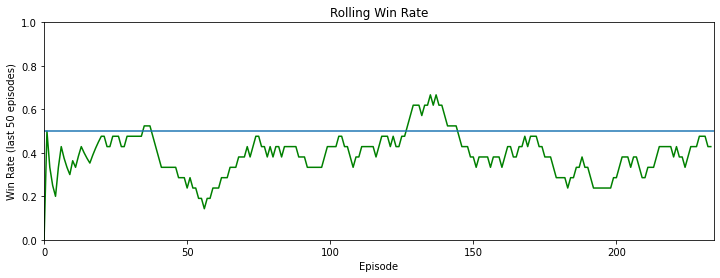

In [20]:
print("The following is the list of snapshots")
print("Columns contain both players' health, both players' mana, and one-hot encoded lists of cards in hand.")
'''snapshot = {

"My_Mana": [self.mana]*length,
"Their_Mana": [opponent.mana]*length,
"My_Health": [self.base_health]*length,
"Their_Health": [opponent.base_health]*length,
"Their_Card_Types_Seen":encodehand(enemy_list) ,
"Their_Currently_Visible_Cards": encodedeployed(opponent.available_squares),
"Active_Cards":encodedeployed(self.available_squares),
"Deck":encodehand(self.deck),
"Action Taken":encodemove(self.move)
}'''
import torch



The following is the list of snapshots
Columns contain both players' health, both players' mana, and one-hot encoded lists of cards in hand.


In [21]:
1e-2

0.01